Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from tensorflow import keras
from PIL import Image

2024-07-25 09:15:02.581341: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 09:15:02.610669: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 09:15:02.747218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 09:15:02.747244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 09:15:02.776548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Define inference class and function

In [2]:
latent_dim = 128 # make sure it matches the model and tensors

stats = pd.read_csv('../Processed Input Images/raw_image_statistics.csv')
aspect_ratio_mean = stats['aspect_ratio_mean'].values[0]
aspect_ratio_std = stats['aspect_ratio_std'].values[0]
tensors_path = "../Best Models & Tensors/224x224_150epochs_10ki/Latent Space Tensors"
decoder_path = "../Best Models & Tensors/224x224_150epochs_10ki/Models/cvae_decoder_model.keras"
save_directory = '../Generated Images 224x224 10ki'

class GenerateImage:
    def __init__(self, class_names, latent_dim=latent_dim, 
                 tensors_path=tensors_path,
                 decoder_path=decoder_path):
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.latent_dim = latent_dim
        self.tensors_path = tensors_path
        self.load_latent_tensors()
        self.counter = 0
        
        # Load the saved decoder model
        self.decoder = keras.models.load_model(decoder_path)

    def load_latent_tensors(self):
        self.z_means = {}
        self.z_log_vars = {}
        for class_name in self.class_names:
            self.z_means[class_name] = np.load(f"{self.tensors_path}/z_mean_{class_name}.npy")
            self.z_log_vars[class_name] = np.load(f"{self.tensors_path}/z_log_var_{class_name}.npy")

    def sample_latent_vector(self, class_name):
        idx = np.random.randint(0, len(self.z_means[class_name]))
        z_mean = self.z_means[class_name][idx]
        z_log_var = self.z_log_vars[class_name][idx]
        epsilon = np.random.normal(size=self.latent_dim)
        return z_mean + np.exp(0.5 * z_log_var) * epsilon

    def generate_image(self, class_name):
        z = self.sample_latent_vector(class_name)
        y = np.zeros((1, self.num_classes))
        y[0, self.class_names.index(class_name)] = 1
        img = self.decoder.predict([z.reshape(1, -1), y])
        img = img.squeeze()
        aspect_ratio = np.random.normal(aspect_ratio_mean, aspect_ratio_std)
        new_height = int(np.sqrt(img.shape[0] * img.shape[1] / aspect_ratio))
        new_width = int(new_height * aspect_ratio)
        img_pil = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        resized_img = np.array(img_pil.resize((new_width, new_height)))
        return resized_img

    def generate_and_save_image(self, class_name):
        resized_img = self.generate_image(class_name)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"Synthetic_{class_name}_{timestamp}_{self.counter}.png"
        self.counter += 1
        save_path = os.path.join(f"{save_directory}/{class_name}", filename)
        plt.imsave(save_path, resized_img, cmap='gray')
        return save_path, resized_img

    def __show(self, class_name, number_of_images):
        # Generate and save only the requested number of images
        for _ in range(number_of_images):
            self.generate_and_save_image(class_name)

        # Display 2x2 grid of example images without saving them
        fig, axes = plt.subplots(2, 2, figsize=(6, 6))
        fig.subplots_adjust(wspace=0, hspace=0)
        for ax in axes.flatten():
            img = self.generate_image(class_name)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        print(f"Example generated images for class: {class_name}")
        plt.show()
        print(f"Total number of images generated and saved: {number_of_images}")

    @staticmethod
    def get_prompt(prompt: str) -> str:
        return prompt.strip()

    def __call__(self, prompt: str, number_of_images: int = 1) -> None:
        class_name = self.get_prompt(prompt)
        assert class_name in self.class_names, f"Unknown class: {class_name}"
        self.__show(class_name, number_of_images)

# Usage
class_names = ['CP 2', 'Disarranged', 'IDA', 'IDA_Disarranged', 'Microtub Abnorm', 'No CP', 'Normal', 'ODA', 'ODA_IDA', 'Subtle CP']
generate = GenerateImage(class_names)

2024-07-25 09:15:03.744737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-25 09:15:03.744944: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Generate images (inference)

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Example generated images for class: IDA


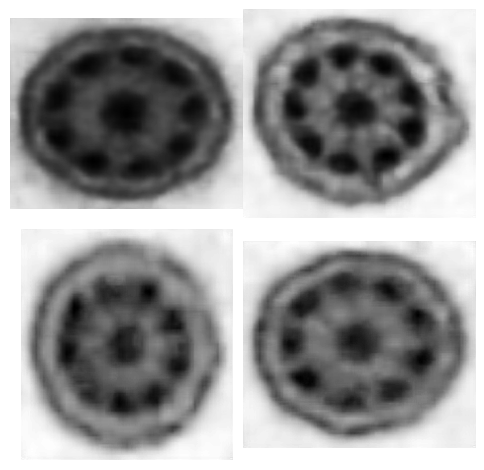

Total number of images generated and saved: 0


In [8]:
image_type = 'IDA'
number_of_images = 0

generate(image_type, number_of_images)